# Recession Forecaster

The United States as of today (October, 2019) has experienced the longest expansion cycle, yet the there are constant talks in the news about an impending recession. Yes, there are signs, such as the recent yield curve inversion, the market corrections in 2018 & 2019, etc. Recessions happen every 10 years or so, are we overdue for one?

The first part is to predict GDP growth, because NBER defines recessions as ['significant decline in economic activity'](https://www.nber.org/cycles.html), not 2 consequtive quarters of deline in real GDP. This means GDP can be growing, albeit at a slow pace, and the economy is still considered in recession.

But due to limitations of the VAR model employed in part 1, it is necessary to employ an alternative method, to ______.

## Part 1

#### Feature Selection

While there are techniques and algorithms to systematically select variables, this is outside the scope of this analysis. Instead, we will rely on domain knowledge. The following factors are considered when selecting input variables:
* Having sufficient data, as recessions are rare occurances.
* Having forward predictive power, which means inflection changes should occur before occur simultaneously as inflection changes in GDP.
* Represent various aspects and mechanisms of the economy, such as a risk free benchmark, or inflation.
* Avoid composite models or indices, as the goal is to construct our own model.

For the GDP decision variable:
* [**Real Gross Domestic Product**](https://fred.stlouisfed.org/series/GDPC1)- Inflation adjusted value of goods and services produced in a year.

For equities, the following variables are considered:
* [**S&P 500**](https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC)- Weighted stock index of 500 companies listed on US exchanges with the largest market cap.
* [S&P 500 Cyclically Adjusted PE Ratio](https://www.quandl.com/data/MULTPL/SHILLER_PE_RATIO_MONTH-Shiller-PE-Ratio-by-Month) [(info)](https://www.investopedia.com/terms/c/cape-ratio.asp)- Normalizes PE ratio fluctuations over 10 year inflation-adjusted earnings. This indicator is used to gauge whether the equities market is over or under-valued.
* [**Nonfinancial Corporate Debt as Percentage of Equity**](https://fred.stlouisfed.org/series/NCBCMDPMVCE)- Contains companies not in the S&P 500. Although this indicator excludes [% of GDP](), valuations of financial and noncorporate companies 

For bonds, the following variables are considered: 
* [10 Year Constant Maturity Minus 3 Month Treasuries Yield Spread](https://fred.stlouisfed.org/series/T10Y3M)- Federal Reserve's main methodology. Financial institutions borrow at low rates short term, to lend at high rates long term. Long term treasury yield tends to be stable, but short term yields are more volatile, and subject to [Federal Reserve interventions]((https://fredblog.stlouisfed.org/2017/02/lets-do-the-twist/)). The data only goes back to 1982, which is not enough to train this model.
* [**10 Year Constant Maturity Minus 3 Month Treasuries Secondary Market Yield Spread**](https://fred.stlouisfed.org/series/TB3MS)- Makes up for the lack of data in the primary market. Primary and secondary market spreads are very close today, due to increased efficiency from electronic trading. Historically, the spread has been higher.
* [10 Year Treasuries Constant Maturity Rate](https://fred.stlouisfed.org/series/DGS10)- Long term treasuries usually reflect investor sentiment regarding long term economic growth. However, this metric alone does not provide evidence of short term liquidity.
* 3 Months Outstanding Repo [(info)](http://law.emory.edu/ecgar/content/volume-5/issue-2/essays/repo-recession-financial-regulation.html)- Before the Great Recession, investment banks used short term repo to inject liquidity to stay afloat. Uptick in short term repo may indicate credit crunch. FRED only has records of contracts with itself as a participant, leaving out the majority of transactions. Data on market transactions were difficult to find.

For inflation, the following indicators are considered:
* [**Consumer Price Index for Urban Consumers**](https://fred.stlouisfed.org/series/CPIAUCSL) [(info)](https://www.bls.gov/opub/btn/volume-3/why-does-bls-provide-both-the-cpi-w-and-cpi-u.htm)- Price inflation covering 88% of Americans, calculated from expenditures. Uses a survey to calculate the basket of goods and services. Basket is updated every 2 years. Selected due to difficulty quantifying intangible traits such as quality.
* [Chained Consumper Price Index for Urban Consumers](https://fred.stlouisfed.org/series/SUUR0000SA0) [(info)](https://www.brookings.edu/blog/up-front/2017/12/07/the-hutchins-center-explains-the-chained-cpi/)- Lacking long term data. Similar to CPI-U, but considers substitution purchases, and weights the changes every month.

For employment, the following indicators are considered:
* [Labor Participation Rate](https://fred.stlouisfed.org/series/CIVPART)- Percent of population over 16 actively seeking or engaged in employment. Too macro driven, such as women participation in the workforce, or retirement of Baby Boomers.
* [**Total Nonfarm Payroll**](https://fred.stlouisfed.org/series/PAYEMS)- Size of the labor force, accounting for 80% of workers who contribute to GDP, excluding propritors, unpaid volunteers, or farm workers.
* [Wage Growth](https://fred.stlouisfed.org/series/CES0500000003)- When labor demand outstrips supply, wages increase, and vise versa. Lack of long term data.

Lastly, the following indicators are not placed in any categories above, but are included because of their predictive power.
* [**Real Private Gross Investment**](https://fred.stlouisfed.org/series/GPDIC1)- Investment represents expenditure on capital goods and residential properties. Provides an indicator for future productivity and GDP growth. Also a strong sign of economic recovery.

The following indicators were considered, but ultimately dismissed.
* [Purchaing Managers' Index](https://www.instituteforsupplymanagement.org/ismreport/mfgrob.cfm?SSO=1)- Locked behind paywall. A survey of supply chain professionals in 19 primary industries.
* [Composite Index of Leading Indicators](https://www.conference-board.org/data/bcicountry.cfm?cid=1) [(info)](https://www.investopedia.com/terms/c/cili.asp)- Locked behind paywall. A composite index of 10 indicators.
* [Consumer Confidence Index](https://www.conference-board.org/data/consumerconfidence.cfm)- Locked behind paywall. A survey of consumer purchases and sentiments.
* [VIX Volativity Index](https://fred.stlouisfed.org/series/VIXCLS)- Describes the volatility, but not the direction, of stocks. Also does not describe economic strength.
* [Effective Federal Funds Rate](https://fred.stlouisfed.org/series/FEDFUNDS)- The most inorganic bond indicator, as the FED has direct control of this rate, which means it is unfiltered by market forces. Secondly, different FED chairs have different doctrines. The FED was fighting inflation in the 70s, deregulation in the 80s, inflation targeting in the 90s & 2000s, then quantitative easing in the 2010s.
* [Personal Savings Rate](https://fred.stlouisfed.org/series/PSAVERT)- Too macro driven, such as women entering workforce, or retirement of Baby Boomers.
* Incremental Capital Outputs Ratio- Hard to find on the web. Calculates how much additional capital investment is needed to create growth.

## Data Preparation

First, import the necessary packages.

In [1]:
import fredapi
import requests
import json
import numpy as np
import pandas as pd
import scipy as sp
from functools import reduce
import math
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import acf
from copy import deepcopy
from dateutil.relativedelta import relativedelta

#### Import FRED Data

To import FRED data, we need an API key. API key can be requested [here](https://research.stlouisfed.org/docs/api/fred/).

Data returned by fredapi module are in Series format. We need to convert them to DataFrame format.

We will also rename the columns so the data become easier to manipulate.

In [2]:
f = fredapi.Fred(api_key='8b91217446b6307d20cb5e4fcfba70eb') # remove API when done

def generate_fred_dataframe(name, series_url):
    return f.get_series(series_url).to_frame().reset_index().rename(columns={'index':'date', 0:name})

# monthly data.
tbill_3m = generate_fred_dataframe('tbill_3m', 'TB3MS')
tbill_10y = generate_fred_dataframe('tbill_10y', 'GS10')
cpiu = generate_fred_dataframe('cpiu', 'CPIAUCSL')
payroll = generate_fred_dataframe('payroll', 'PAYEMS')
# quarterly data
dtoe = generate_fred_dataframe('dtoe', 'NCBCMDPMVCE')
pinvest = generate_fred_dataframe('pinvest', 'GPDIC1')
gdp = generate_fred_dataframe('gdp', 'GDPC1')

#### Import Quandl Data

In [3]:
quandl_api_key = '8ufKe7Y2JMsYPU3CGN7m'

def generate_quandl_dataframe(name, series_url):
    res = pd.DataFrame.from_dict(requests.get(series_url.format(quandl_api_key)).json()['dataset']['data'])
    res = res[::-1].rename(columns={0:'date', 1:name})
    res['date'] = res['date'].astype('datetime64')
    return res

sp500 = generate_quandl_dataframe('sp500', 'https://www.quandl.com/api/v3/datasets/MULTPL/SP500_REAL_PRICE_MONTH.json?api_key={}')
sp500_cape = generate_quandl_dataframe('sp500_cape', 'https://www.quandl.com/api/v3/datasets/MULTPL/SHILLER_PE_RATIO_MONTH.json?api_key={}')
sp500_pe = generate_quandl_dataframe('sp500_pe', 'https://www.quandl.com/api/v3/datasets/MULTPL/SP500_PE_RATIO_MONTH.json?api_key={}')

#### Converting Quarterly to Monthly Data

To convert quarterly to monthly data, we will call the "resample" method.

In [4]:
dtoe = dtoe.set_index('date').resample('MS').asfreq()
pinvest = pinvest.set_index('date').resample('MS').asfreq()
gdp = gdp.set_index('date').resample('MS').asfreq()

#### Interpolate Null Values

Newly resampled months have null values, we will use [cublic spline interpolation](https://columbiaeconomics.com/2010/01/20/how-economists-convert-quarterly-data-into-monthly-cubic-spline-interpolation/), a technique commonly used by economists, to fill in the missing values. Cubic spline has better smoothing over quadratic interpolation.

Interpolation converts data to Series. We need to convert back to DataFrame type.

In [5]:
gdp['gdp'] = gdp['gdp'].interpolate(method='spline', order=3)
dtoe['dtoe'] = dtoe['dtoe'].interpolate(method='spline', order=3)
pinvest['pinvest'] = pinvest['pinvest'].interpolate(method='spline', order=3)

pinvest.head(2)

,pinvest
date,
1947-01-01,218.091000
1947-02-01,218.755551


#### Merge Datasets

Note that variables have different start dates, merging the datasets will automatically trim the start dates.

In [6]:
print(tbill_3m.head(1))
print(tbill_10y.head(1))
print(cpiu.head(1))

        date  tbill_3m
0 1934-01-01      0.72
        date  tbill_10y
0 1953-04-01       2.83
        date   cpiu
0 1947-01-01  21.48


In [7]:
data = [tbill_3m, tbill_10y, cpiu, payroll, dtoe, pinvest, sp500, sp500_cape, sp500_pe, gdp]
data = reduce(lambda left,right: pd.merge(left,right,on='date'), data)
data = data.set_index('date')

data.head(2)

,tbill_3m,tbill_10y,cpiu,payroll,dtoe,pinvest,sp500,sp500_cape,sp500_pe,gdp
date,,,,,,,,,,
1953-04-01,2.19,2.83,26.69,50435.0,65.279067,288.445000,24.71,12.16,10.06,2718.709000
1953-05-01,2.16,3.05,26.70,50490.0,66.332646,288.354558,24.84,12.14,10.00,2717.383346


Verify there are no null values, else further processing is needed.

In [8]:
data.isnull().sum()

tbill_3m      0
tbill_10y     0
cpiu          0
payroll       0
dtoe          0
pinvest       0
sp500         0
sp500_cape    0
sp500_pe      0
gdp           0
dtype: int64

#### Deriving Correct Treasury Spread

FRED have a graph, not series of data on [10 year - 3 month spread](https://fred.stlouisfed.org/graph/?g=oGg). We have to creat our own.

In [9]:
data['tbill_10y'] = data['tbill_10y'] - data['tbill_3m']
data = data.drop('tbill_3m', axis=1).rename(columns={'tbill_10y':'tbill'})

In [10]:
data.tail(2)

,tbill,cpiu,payroll,dtoe,pinvest,sp500,sp500_cape,sp500_pe,gdp
date,,,,,,,,,
2019-03-01,0.17,254.148,150796.0,31.74998,3451.592302,2803.98,29.58,20.86,18995.542371
2019-04-01,0.15,254.958,151012.0,32.87862,3424.653000,2903.80,30.13,21.56,19021.860000


### Preliminary Analysis

There are 793 months of data in the dataset.

In [11]:
data.describe()

,tbill,cpiu,payroll,dtoe,pinvest,sp500,sp500_cape,sp500_pe,gdp
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,1.477011,116.719218,98634.532156,53.327181,1389.294990,606.309710,19.850038,18.543304,9204.319173
std,1.163736,75.631481,31731.058247,19.541533,925.367653,697.402763,7.651430,11.215692,4910.712193
min,-2.650000,26.690000,48826.000000,27.378639,258.848094,23.270000,6.640000,6.790000,2648.982400
25%,0.620000,37.300000,70792.000000,37.850009,586.065429,91.110000,14.610000,12.890000,4938.993968
50%,1.450000,109.500000,99121.000000,45.765423,1143.204581,237.400000,19.620000,17.420000,8185.303000
75%,2.410000,181.200000,130666.000000,67.745365,2222.864484,1122.080000,24.350000,20.860000,13559.032000
max,4.420000,254.958000,151012.000000,102.570130,3481.088000,2903.800000,44.190000,123.730000,19021.860000


#### Data Visualization

In [12]:
def choose_subplot_dimensions(k):
    '''sets nrow and ncol parameter in plots based on number of rows'''
    if k < 4:
        return k, 1
    elif k < 9:
        return math.ceil(k/2), 2
    else:
        return math.ceil(k/3), 3

def generate_subplots(k, row_wise=False):
    nrow, ncol = choose_subplot_dimensions(k)
    figure, axes = plt.subplots(nrow, ncol, dpi=120, figsize=(10, 4), sharey=False)

    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        axes = axes.flatten(order=('C' if row_wise else 'F'))
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1

            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)

        axes = axes[:k]
        return figure, axes

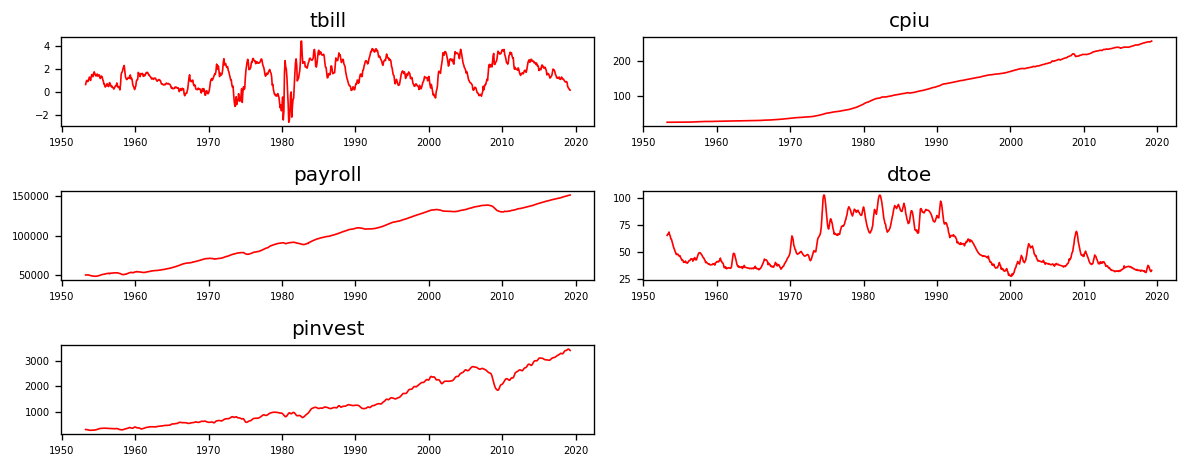

In [13]:
fig, axes = generate_subplots(int(math.ceil(len(data.columns) / 2)), row_wise=True)
for col, ax in enumerate(axes.flatten()):
    ax.plot(data[data.columns[col]], color='red', linewidth=1)
    ax.set_title(data.columns[col])
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

#### Check for Correlation

In [14]:
def generate_corr_heatmap(data_input):
    plt.figure(figsize = (10,5))
    ax = sb.heatmap(data_input.corr(), 
                    xticklabels=data_input.columns.values, 
                    yticklabels=data_input.columns.values, 
                    annot=True, annot_kws={'size':12})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

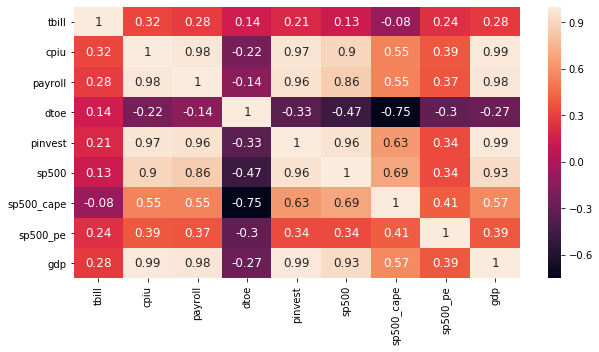

In [15]:
generate_corr_heatmap(data)

CPIU, PAYROLL, PINVEST, and GDP are highly correlated. This could create problems of multicollinearity. Multicollinearity reduces the statistical significance of the variables, making it difficult to pinpoint which variable is responsible for changes in GDP.

Going back to the criteria set at the beginning, CPIU and PAYROLL will be removed. While PINVEST have larger variance, which may obsecure the signal, PINVEST is kept because it has the earliest inflection point.

#### Model Selection

For dealing with multiple variables, a vector autoregression (VAR) model is right for the job.

VAR is a stochastic (random) process that captures linear relationship between all variables. VAR assumes all variables are dependent on each other, and that change in 1 variable will induce change in another. This trait is called Granger causality. We can verify if we should reject this hypothesis.

#### Test for Autocorrelation

GDP is highly autocorrelated. While this feature can allow a generalization of GDP trend (2% year-over-year growth), we are interested in the short term fluctuations. Having high autocorrelation does not help to delect these fluctuations.

** Expalin full vs. partial autocorrelation **.

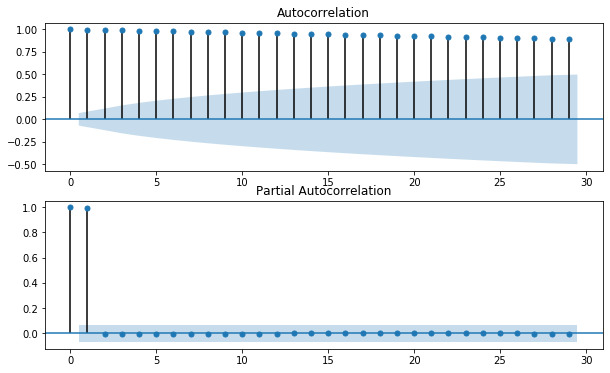

In [16]:
fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(data.gdp, ax=ax[0])
ax[1] = plot_pacf(data.gdp, ax=ax[1])

#### Test for Stationarity

It is also important for all data to be stationary, meaning the mean and variance do not change overtime. The primary feature to eliminate is trend, for example: GDP increases steadily over the years, the mean increases as time increases, and so does the variance. At the current trend, as time approaches infinity, so does the mean and variance. Many data models do not deal with changing mean and variance very well.

In [17]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        
    def ADF_Stationarity_Test(self, timeseries):
        adfTest = adfuller(timeseries, autolag='AIC')
        self.pValue = adfTest[1]
        
        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags','# Observations'])
        dfResults['Critical Value 5%'] = adfTest[4]['5%']

        print(dfResults)
        
sTest = StationarityTests()

In [18]:
for var in data:
    sTest.ADF_Stationarity_Test(data[var])
    print('Is {} series stationary? {}'.format(var, sTest.isStationary))
    print('\n')

ADF Test Statistic     -5.092447
P-Value                 0.000015
# Lags                 16.000000
# Observations        776.000000
Critical Value 5%      -2.865272
dtype: float64
Is tbill series stationary? True


ADF Test Statistic      1.765773
P-Value                 0.998279
# Lags                 15.000000
# Observations        777.000000
Critical Value 5%      -2.865267
dtype: float64
Is cpiu series stationary? False


ADF Test Statistic     -0.174749
P-Value                 0.941465
# Lags                  4.000000
# Observations        788.000000
Critical Value 5%      -2.865215
dtype: float64
Is payroll series stationary? False


ADF Test Statistic     -1.102667
P-Value                 0.714007
# Lags                 21.000000
# Observations        771.000000
Critical Value 5%      -2.865296
dtype: float64
Is dtoe series stationary? False


ADF Test Statistic      0.369847
P-Value                 0.980332
# Lags                 17.000000
# Observations        775.000000
Criti

#### Data Transformation

To make our data stationary, we will take the first difference of month(t):
y_t - y_(t-1)

In [19]:
data_trans = data.diff().dropna()

#### Splitting Data Into Trainng and Testing Sets

In [20]:
test_periods = 12
train, test = data[0:-test_periods], data[-test_periods:]
train_trans = data_trans[0:-test_periods]
train_trans.tail()

,tbill,cpiu,payroll,dtoe,pinvest,sp500,sp500_cape,sp500_pe,gdp
date,,,,,,,,,
2017-12-01,-0.04,0.569,174.0,-0.052226,18.895159,70.73,0.79,0.44,35.370950
2018-01-01,0.09,0.983,171.0,-0.210209,9.798073,125.46,1.22,0.72,40.482189
2018-02-01,0.12,0.485,330.0,-0.142943,-8.330912,-84.64,-1.27,-1.15,50.168122
2018-03-01,-0.15,0.129,182.0,-0.303059,-9.314876,-2.39,-0.23,-0.41,51.159989
2018-04-01,-0.03,0.458,196.0,0.403522,2.390788,-49.14,-0.84,-0.88,58.552889


Checking for autocorrelation, much have been eliminated, but some degrees 

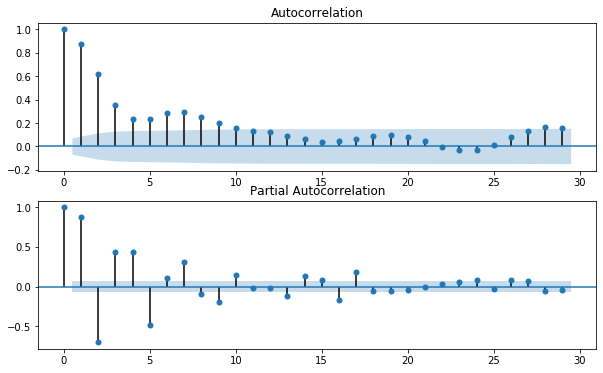

In [21]:
fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(train_trans.gdp, ax=ax[0])
ax[1] = plot_pacf(train_trans.gdp, ax=ax[1])

In [22]:
for var in train:
    sTest.ADF_Stationarity_Test(train_trans[var])
    print("Is {} series stationary? {}".format(var, sTest.isStationary))
    print('\n')

ADF Test Statistic   -7.528932e+00
P-Value               3.621770e-11
# Lags                1.900000e+01
# Observations        7.600000e+02
Critical Value 5%    -2.865350e+00
dtype: float64
Is tbill series stationary? True


ADF Test Statistic     -3.610977
P-Value                 0.005555
# Lags                 16.000000
# Observations        763.000000
Critical Value 5%      -2.865335
dtype: float64
Is cpiu series stationary? True


ADF Test Statistic   -5.693672e+00
P-Value               7.964242e-07
# Lags                3.000000e+00
# Observations        7.760000e+02
Critical Value 5%    -2.865272e+00
dtype: float64
Is payroll series stationary? True


ADF Test Statistic   -7.846457e+00
P-Value               5.751861e-12
# Lags                2.100000e+01
# Observations        7.580000e+02
Critical Value 5%    -2.865361e+00
dtype: float64
Is dtoe series stationary? True


ADF Test Statistic   -5.867333e+00
P-Value               3.301907e-07
# Lags                1.300000e+01
# Obs

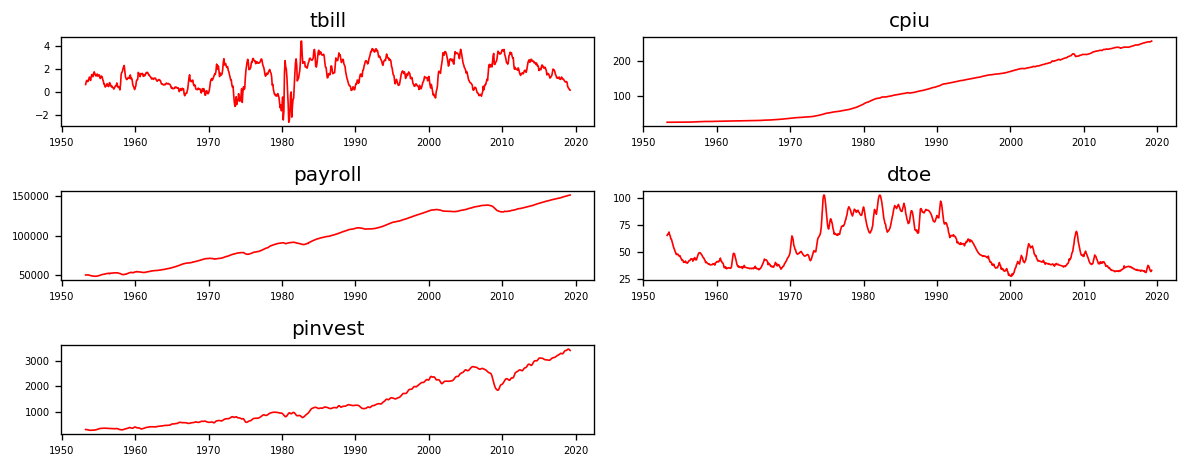

In [23]:
fig, axes = generate_subplots(int(math.ceil(len(data.columns) / 2)), row_wise=True)
for col, ax in enumerate(axes.flatten()):
    ax.plot(data[data.columns[col]], color='red', linewidth=1)
    ax.set_title(data.columns[col])
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

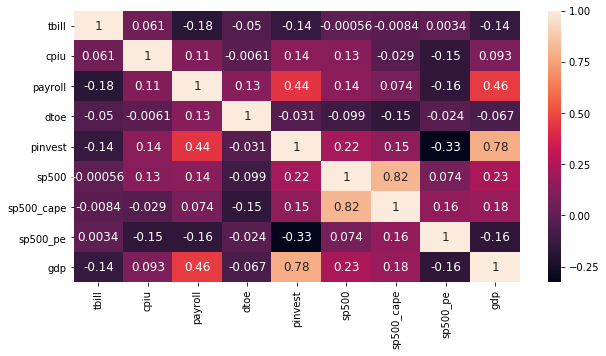

In [24]:
generate_corr_heatmap(train_trans)

#### Lag Order Selection

VAR uses 4 metrics for lag order selection: 

* Aikaike Information Criterion (AIC)
* Baysian Information Criteron (BIC) 
* Final Prediction Error (FPE)
* Hannan-Quinn Information Criterion (HQIC)

Not getting into the specific mechanics, these four metrics return the error value. We want the lag orders with the lowest error value. 

https://stats.stackexchange.com/questions/246886/selecting-lag-order-for-var-and-vecm

AIC has the tendency to chooose large lag order, while BIC has the tendency to choose small lag order. For that reason, the average of AIC and BIC will be used. The average lag order is 14.5, so we will select 15.

In [25]:
train_model = VAR(data_trans)
train_model.select_order(maxlags=36).summary()

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,25.34,25.39,1.009e+11,25.36
1,20.98,21.53,1.297e+09,21.20
2,19.10,20.14,1.964e+08,19.50
3,18.58,20.13,1.177e+08,19.18
4,17.74,19.78,5.077e+07,18.53
5,17.19,19.73*,2.937e+07,18.17
6,16.94,19.97,2.282e+07,18.11
7,16.67,20.20,1.752e+07,18.03*
8,16.52,20.55,1.508e+07,18.07
9,16.41,20.93,1.356e+07,18.16


#### Granger Causality & Cointegration Test

Granger causality test assumes there is no relationship between the lag value of x(row) and present value of y(column), if resultant p value is greater than 0.05.

The heat map below indicates *pinvest* has no causality relations, but the p-value is not too far from the threshold. While this raises red flag regarding our model, implying different variable and transformation selection methods should be employed, we can verify the merit of this interpretation through cointegration test.

In [26]:
data = [tbill_3m, tbill_10y, cpiu, payroll, dtoe, pinvest, sp500, sp500_cape, sp500_pe, gdp]
data = reduce(lambda left,right: pd.merge(left,right,on='date'), data)
data = data.set_index('date')

data['tbill_10y'] = data['tbill_10y'] - data['tbill_3m']
data = data.drop('tbill_3m', axis=1).rename(columns={'tbill_10y':'tbill'})

In [27]:
data = data.drop(['tbill', 'sp500_cape', 'cpiu', 'pinvest'], axis=1)

In [28]:
data_trans = data.diff().dropna()

In [29]:
lag_order = 22

def grangerstest(data_input, variables, test='ssr_chi2test'):
    res = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in data_input.columns:
        for r in res.index:
            granger_res = grangercausalitytests(data_input[[r, c]], maxlag=lag_order, verbose=False)
            p_values = [round(granger_res[i+1][0][test][1],4) for i in range(lag_order)]

            res.loc[r, c] = min(p_values)
    res.columns = [var + '_x' for var in variables]
    res.index = [var + '_y' for var in variables]
    return res

def generate_pval_map(data_input):
    gct = grangerstest(data_input, variables=data_input.columns)
    cmap1 = ListedColormap(['r'])

    plt.figure(figsize = (10,5))
    ax = sb.heatmap(gct, 
            xticklabels=gct.columns.values, 
            yticklabels=gct.index.values, 
                mask=gct < 0.05, cmap=cmap1, cbar=False, 
                annot=True, annot_kws={'size':12})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.show()

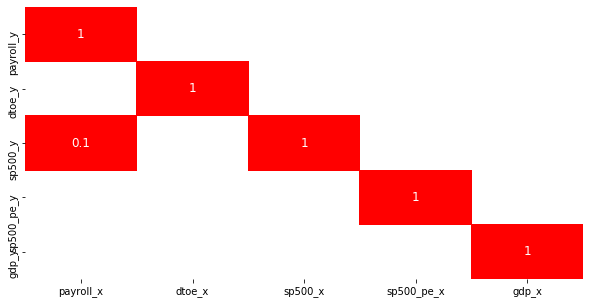

In [30]:
generate_pval_map(data_trans)

Cointegration is simply that by lagging one variable against another (order of integration or lag order), the distance between variables is stationary throughout time. If two variables are cointegrated, there must be granger causality (even if a weak one, or one way causality).

Johansen test combines two series together, than tests whether this combined series has less order of integration than a single variable on its own. If so, then the variables are cointegrated.

Here we pass in 3 variables:
1. data,
2. 1 for stochastic nature of the data,
3. number of lagged periods.

While there are many literature on whether the economy is [deterministic or stochastic](https://fraser.stlouisfed.org/files/docs/historical/frbsf/frbsf_let/frbsf_let_19930212.pdf), with proponents of a deterministic model arguing GDP hinders on the long term supply factors, such as capital, labor, and technology, and that growth rate should stay the same overtime; while proponents of a stochastic model would point to "permanent" changes to the growth rate, positive or negative, such as sudden sharp slope increase in supply factors since the industrial revolution. Under a deterministic model, proponents of stochastic model would say, people would still be living in the 17th century.

Testing lag order of 15, *gdp* fails the cointegration test, so we will decrease the lag order until all four variables are cointegrated. We do not want the lag order to be too small, as small lag orders tend to be autocorrelated.

Below is a modified function to find the highest lag order that satisfies the cointegration test.

In [31]:
def cointegration_test(data, det_order, lag_order, significance=0.05):
    out = coint_johansen(data, det_order, lag_order)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-significance)]]

    def adjust(val, length=6): return str(val).ljust(length)
    print('Name   ::  Test Stat  >  C(95%)    => Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), '> ', adjust(cvt, 8), ' => ', trace > cvt)
        
cointegration_test(data_trans, det_order=-1, lag_order=15)

Name   ::  Test Stat  >  C(95%)    => Signif  
 ----------------------------------------
payroll ::  231.87    >  60.0627   =>  True
dtoe   ::  120.65    >  40.1749   =>  True
sp500  ::  59.34     >  24.2761   =>  True
sp500_pe ::  25.8      >  12.3212   =>  True
gdp    ::  5.23      >  4.1296    =>  True


In [32]:
def cointegration_test_lag_order_detection(data, det_order, lag_order, significance=0.05):
    out = coint_johansen(data, det_order, lag_order)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-significance)]]
    res = traces > cvts
    return res

for i in reversed(range(7, 27)):
    print('lag order:', i, cointegration_test_lag_order_detection(data_trans, det_order=-1, lag_order=i))

lag order: 26 [ True  True  True  True False]
lag order: 25 [ True  True  True  True False]
lag order: 24 [ True  True  True  True False]
lag order: 23 [ True  True  True  True False]
lag order: 22 [ True  True  True  True False]
lag order: 21 [ True  True  True  True False]
lag order: 20 [ True  True  True  True False]
lag order: 19 [ True  True  True  True False]
lag order: 18 [ True  True  True  True False]
lag order: 17 [ True  True  True  True False]
lag order: 16 [ True  True  True  True False]
lag order: 15 [ True  True  True  True  True]
lag order: 14 [ True  True  True  True  True]
lag order: 13 [ True  True  True  True  True]
lag order: 12 [ True  True  True  True  True]
lag order: 11 [ True  True  True  True  True]
lag order: 10 [ True  True  True  True  True]
lag order: 9 [ True  True  True  True  True]
lag order: 8 [ True  True  True  True  True]
lag order: 7 [ True  True  True  True  True]


#### VAR Model

In [33]:
lag_order = 15
train_model_fitted = train_model.fit(lag_order)
train_model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Nov, 2019
Time:                     12:39:50
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    23.4476
Nobs:                     777.000    HQIC:                   18.9350
Log likelihood:          -14958.9    FPE:                1.02898e+07
AIC:                      16.1139    Det(Omega_mle):     2.40969e+06
--------------------------------------------------------------------
Results for equation tbill
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.056311         0.029342            1.919           0.055
L1.tbill               0.220232         0.039511            5.574           0.000
L1.cpiu                0.039502         0.040215        

#### Check for Residual Correlation with Durbin Watson Test

If our transformation and lag order selection is done correctly, there should be little to no correlation between the residual errors. The existance of residual correlation implies unexplained pattern.

Result values can range beween 0 to 4, with 0-2 indicating a positive correlation, and 2-4 indicating negative correlation. It is generally acceptable for values to be between 1.5 to 2.5.

In [34]:
for col, val in zip(train_trans.columns, durbin_watson(train_model_fitted.resid)):
    print((col), ':', round(val, 2))

tbill : 2.0
cpiu : 1.99
payroll : 2.01
dtoe : 1.97
pinvest : 1.95
sp500 : 2.0
sp500_cape : 2.0
sp500_pe : 2.02
gdp : 1.93


#### Forecasting GDP

In [35]:
train_forecast_input = train_trans.values[-lag_order:]
train_forecast_input

array([[-2.00000000e-02,  1.81000000e-01,  1.41000000e+02,
        -4.45582936e-01,  7.17018057e+00,  5.47900000e+01,
         6.00000000e-01,  9.00000000e-02,  2.99602986e+01],
       [-1.60000000e-01, -2.12000000e-01,  1.27000000e+02,
        -2.25948227e-01,  6.79207475e+00,  3.69100000e+01,
         4.30000000e-01, -8.00000000e-02,  2.94756224e+01],
       [-2.40000000e-01,  3.02000000e-01,  2.13000000e+02,
         6.56662642e-01,  1.36707447e+01, -7.51000000e+00,
        -1.90000000e-01, -3.60000000e-01,  3.63560790e+01],
       [-9.00000000e-02, -8.90000000e-02,  1.28000000e+02,
        -9.32443536e-01,  1.72541943e+01,  3.60400000e+01,
         4.10000000e-01,  7.00000000e-02,  4.19243874e+01],
       [-2.00000000e-01,  2.20000000e-01,  2.29000000e+02,
        -3.18754686e-02,  2.17102137e+01,  3.86400000e+01,
         4.40000000e-01,  9.00000000e-02,  4.87953517e+01],
       [ 4.00000000e-02,  2.08000000e-01,  2.04000000e+02,
         3.07385985e-01,  1.83565920e+01,  2.011000

In [36]:
train_forecast = pd.DataFrame(train_model_fitted.forecast(train_forecast_input, test_periods), 
                        index=data_trans.index[-test_periods:], 
                        columns=data_trans.columns)

train_forecast

ValueError: Shape of passed values is (12, 9), indices imply (12, 5)

#### Inverting Transformation

In [ ]:
train_forecast_reverse = train_forecast.cumsum() + train.iloc[-1, :]
train_forecast_reverse

In [ ]:
# for i, (col,ax) in enumerate(zip(train_forecast_reverse.columns, axes.flatten())):
#     train_forecast_reverse[col].plot(color='red', label='prediction', legend=True, ax=ax).autoscale(axis='x',tight=True)
#     test[col].plot(color='blue', label='actual', legend=True, ax=ax);
#     ax.set_title(col + ": Forecast vs Actuals")
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)

# plt.tight_layout();

fig, axes = generate_subplots(int(math.ceil(len(train_forecast_reverse.columns) / 2)), row_wise=True)
for col, ax in enumerate(axes.flatten()):
    train_forecast_reverse[col].plot(color='red', label='prediction', legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col].plot(color='blue', label='actual', legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.show()

For some reason this model was not able 

* MAPE- 
* ME- 
* MAE- 
* MPE- 
* RMSE- 
* Minmax- 

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [ ]:
def print_forecast_accuracy(forecast, actual):
    for c in forecast:
        print('Forecast Accuracy of {}'.format(c))
        accuracy_prod = forecast_accuracy(forecast[c].values, actual[c])
        for k, v in accuracy_prod.items():
            print(k, ': ', round(v,4))
        print('\n')

print_forecast_accuracy(forecast=train_forecast_reverse, actual=test)

In [ ]:
# model = VAR(data_trans)
# model_fitted = train_model.fit(lag_order)

# forecast = pd.DataFrame(train_model_fitted.forecast(data_trans.values[-lag_order:], test_periods), 
#                         index=data_trans.index[-test_periods:],
#                         columns=data_trans.columns)
# forecast_reverse = forecast.cumsum() + data.iloc[-1, :]

# forecast_reverse.index = pd.date_range(pd.to_datetime('2019, 05, 1'), pd.to_datetime('2020, 04, 1'), freq='MS')
# forecast

In [ ]:
# fig, axes = plt.subplots(nrows=int(len(forecast_reverse.columns)/2), ncols=2, dpi=120, figsize=(10,6))
# for i, (col,ax) in enumerate(zip(forecast_reverse.columns, axes.flatten())):
#     test[col].plot(color='blue', label='actual', legend=True, ax=ax)
#     forecast_reverse[col].plot(color='red', label='prediction', legend=True, ax=ax).autoscale(axis='x',tight=True);
#     ax.set_title(col + ": Forecast")
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)

# plt.tight_layout();

#### Consolidate Formula

In [ ]:
def var_combined(data_input, lag_order, start_date, test_periods=(2*lag_order)):
    '''return start date'''
    start_date = pd.to_datetime(start_date)
    
    '''return dates for graphing'''
    data_baseline = data_input.loc[(data_input.index >= start_date - relativedelta(months=2 * test_periods)) & 
                                    (data_input.index <= start_date + relativedelta(months=test_periods))]
    
    '''transform first difference'''
    data_diff = data_input.diff().dropna()
    data_diff = data_diff.loc[data_diff.index <= start_date]

    '''VAR model'''
    model = VAR(data_diff)
    model_fitted = train_model.fit(lag_order)
    forecast_diff = pd.DataFrame(
        model_fitted.forecast(data_diff.values[-lag_order:], test_periods), 
        index=data_diff.index[-test_periods:], columns=data_diff.columns
    )
    
    '''invert transformation'''
    forecast_reverse = forecast_diff.cumsum() + data_input.iloc[data_input.index == start_date].squeeze()
#     forecast_reverse.index = pd.date_range(pd.to_datetime('2019, 05, 1'), pd.to_datetime('2020, 04, 1'), freq='MS')
    forecast_reverse.index = pd.date_range(start_date + relativedelta(months=1), start_date + 
                                           relativedelta(months=test_periods), freq='MS')

    '''display graphs'''
    fig, axes = plt.subplots(nrows=int(ceil(len(forecast_reverse.columns) / 2)), ncols=2, dpi=120, figsize=(10, 4))
    for i, (col,ax) in enumerate(zip(forecast_reverse.columns, axes.flatten())):
        data_baseline[col].plot(color='blue', label='actual', legend=True, ax=ax)
        forecast_reverse[col].plot(color='red', label='prediction', legend=True, ax=ax).autoscale(axis='x',tight=True);
        ax.set_title(col + ": Forecast")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
        plt.tight_layout();

In [ ]:
var_combined(data, lag_order=15, start_date='2019, 4')

## Findings

## Limitations

#### Feature Selection

This predictor does not pinpoint the cause of a recession, but makes a general comment about the state of the economy. The underlying assumption is that these inputs are efficient enough to reflect long term market conditions, but inefficient enough to price in the short term fluctuations in GDP.

When trying to quantify debt as percentage of equity, it turned out that noncoporate entities 

The model only accepts data input from the determined lag order, meaning only 15 months of data was used.  The limited dataset does not include a recession, meaning the w

#### VAR Model

## Part 2

#### Data Preparation

Let's set up recession decision variable. Difficulty joining series, so had to convert to list, append, then reconvert to series.

In [ ]:
# possible to create lambda variables?
r_1953 = pd.Series(pd.date_range(pd.to_datetime('1953, 3, 1'), pd.to_datetime('1954, 5, 1'))).tolist()
r_1957 = pd.Series(pd.date_range(pd.to_datetime('1957, 8, 1'), pd.to_datetime('1958, 4, 1'))).tolist()
r_1960 = pd.Series(pd.date_range(pd.to_datetime('1960, 4, 1'), pd.to_datetime('1961, 2, 1'))).tolist()
r_1962 = pd.Series(pd.date_range(pd.to_datetime('1969, 12, 1'), pd.to_datetime('1970, 11, 1'))).tolist()
r_1973 = pd.Series(pd.date_range(pd.to_datetime('1973, 11, 1'), pd.to_datetime('1975, 3, 1'))).tolist()
r_1980 = pd.Series(pd.date_range(pd.to_datetime('1980, 1, 1'), pd.to_datetime('1980, 7, 1'))).tolist()
r_1981 = pd.Series(pd.date_range(pd.to_datetime('1981, 7, 1'), pd.to_datetime('1982, 11, 1'))).tolist()
r_1990 = pd.Series(pd.date_range(pd.to_datetime('1990, 7, 1'), pd.to_datetime('1991, 3, 1'))).tolist()
r_2001 = pd.Series(pd.date_range(pd.to_datetime('2001, 3, 1'), pd.to_datetime('2001, 11, 1'))).tolist()
r_2007 = pd.Series(pd.date_range(pd.to_datetime('2007, 12, 1'), pd.to_datetime('2009, 6, 1'))).tolist()

print('Original series length:', len(r_1953))

recession_months = pd.Series(r_1953 + r_1957 + r_1960 + r_1962 + r_1973 + r_1980 + r_1981 + r_1990 + r_2001 + r_2007)

# Create a DataFrame for recession
start_date = pd.to_datetime('1953, 4')
end_date = pd.to_datetime('today')
recessions = pd.date_range(start_date, end_date, freq='MS')
recessions = recessions.to_frame().reset_index()

# Mark recession months as 1, non-recession months as 0
recessions.iloc[:,1] = 0
recessions.loc[recessions.iloc[:,0].isin(recession_months), 0] = 1
recessions.rename(columns={'index':'date', 0:'recession'}, inplace=True)


print('Verify series was appended:', len(recession_months))

recessions.iloc[15:20]

## Closing Thoughts

Special thanks to Mortada Mehyar for creating [fredapi](https://github.com/mortada/fredapi). This saved some time from having to deal with JSON format.